In [ ]:
#1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from keras import models, layers
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import Sequential, regularizers
from keras.layers import LSTM, Embedding, Dropout, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

tokenizer = None
model = None
sentiment_amount = 2
sentiments = ["Negative", "Positive"]

In [ ]:
#2. LOAD DATASET & CONCAT
dataset1 = pd.read_csv("Anies Baswedan.csv")
dataset2 = pd.read_csv("Prabowo Subianto.csv")
dataset3 = pd.read_csv("Ganjar Pranowo.csv")
df = pd.concat([dataset1, dataset2, dataset3])

# DROP
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1', ' Date', ' Created', ' User ID', ' Followers', ' Following', ' Tweet Count', ' TweetLocation'], axis=1)
df = df.dropna(axis=0)

df = shuffle(df).reset_index(drop=True)

#DROP 10.000 DATA (UNDERSAMPLING)
index = df[df.label == 'Positive'].index
n = 0
for i in index:
  if n != 10000:
    df = df.drop(i)
    n = n + 1
  else:
    break

print(df['label'].value_counts())
print(df.shape)

label
Positive    11654
Negative     8074
Name: count, dtype: int64
(19728, 2)


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#PREPROCESS DATASET
def get_dataset():
    dataset = df.copy(deep=True)

    for index, data in dataset.iterrows():
        text = data['Text']
        text = str(text).lower()
        word_list = word_tokenize(text)
        eng_stopwords = stopwords.words('english')
        word_list = [word for word in word_list if word not in eng_stopwords]

        text = ' '.join(word_list)
        dataset.at[index, 'Text'] = text

    dataset = dataset.sample(frac = 1) #ambil seluruh data pada dataset

    return dataset

In [ ]:
#DATASET TO SEQUENCES
def preprocess_data(text_list, sentiments):
    global tokenizer
    if tokenizer == None:
        initialize_tokenizer()

    sequences = tokenizer.texts_to_sequences(text_list)

    x = pad_sequences(sequences)
    le = LabelEncoder()
    y = le.fit_transform(sentiments)

    return x, y

In [ ]:
def initialize_tokenizer():
    dataset = get_dataset()
    global tokenizer
    tokenizer = Tokenizer(num_words=4000) #ambil yang paling sering muncul
    tokenizer.fit_on_texts(dataset['Text'])

In [ ]:
def get_word_count():
    global tokenizer
    if tokenizer == None:
        initialize_tokenizer()
    return len(tokenizer.word_index)

In [ ]:
#HYPERPARAMETER TUNNING
def create_model(embedding_dim=200, lstm_units=64, dense_units=32, dropout_rate=0.2, optimizer='rmsprop', epochs=10, batch_size=16):
    word_count = get_word_count()
    model = models.Sequential([
        layers.Embedding(input_dim=word_count + 1, output_dim=embedding_dim),
        layers.LSTM(lstm_units, return_sequences=True),
        layers.LSTM(lstm_units // 2),
        layers.Dense(dense_units, activation='relu',
                     kernel_regularizer=regularizers.l2(0.01),
                     activity_regularizer=regularizers.l1(0.01)),
        layers.Dropout(dropout_rate),
        layers.Dense(dense_units // 2, activation='relu'),
        layers.Dropout(dropout_rate / 2),
        layers.Dense(1, activation='sigmoid')  # Single neuron with sigmoid activation for binary classification
    ])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
dataset = get_dataset()
x, y = preprocess_data(dataset['Text'], dataset['label'])
x = np.array(x)
y = np.array(y)

In [ ]:
#MODEL ARCHITECTURE
word_count = get_word_count()
model = models.Sequential([
  layers.Embedding(input_dim=word_count, output_dim=300),
  layers.LSTM(64, return_sequences=True),
  layers.LSTM(32),
  layers.Dense(32, activation='relu',
              kernel_regularizer=regularizers.l2(0.01),
              activity_regularizer=regularizers.l1(0.01)),
  layers.Dropout(0.2),
  layers.Dense(16, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) #binary => positive negative

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 300)         4292700   
                                                                 
 lstm_10 (LSTM)              (None, None, 64)          93440     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_15 (Dense)            (None, 32)                1056      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dropout_11 (Dropout)        (None, 16)               

#Original After Hyperparameter Tuning (RMSProp)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto'))

Epoch 1/10
744/744 [==============================] - 78s 99ms/step - loss: 0.4766 - accuracy: 0.8216 - val_loss: 0.3755 - val_accuracy: 0.8624
Epoch 2/10
744/744 [==============================] - 71s 95ms/step - loss: 0.2998 - accuracy: 0.8937 - val_loss: 0.2783 - val_accuracy: 0.8920
Epoch 3/10
744/744 [==============================] - 75s 100ms/step - loss: 0.2472 - accuracy: 0.9162 - val_loss: 0.2596 - val_accuracy: 0.9014
Epoch 4/10
744/744 [==============================] - 71s 95ms/step - loss: 0.2159 - accuracy: 0.9266 - val_loss: 0.2716 - val_accuracy: 0.9068
Epoch 5/10
744/744 [==============================] - 73s 98ms/step - loss: 0.1930 - accuracy: 0.9368 - val_loss: 0.2396 - val_accuracy: 0.9159
Epoch 6/10
744/744 [==============================] - 73s 98ms/step - loss: 0.1746 - accuracy: 0.9436 - val_loss: 0.2438 - val_accuracy: 0.9129
Epoch 7/10
744/744 [==============================] - 71s 96ms/step - loss: 0.1575 - accuracy: 0.9513 - val_loss: 0.2484 - val_accuracy

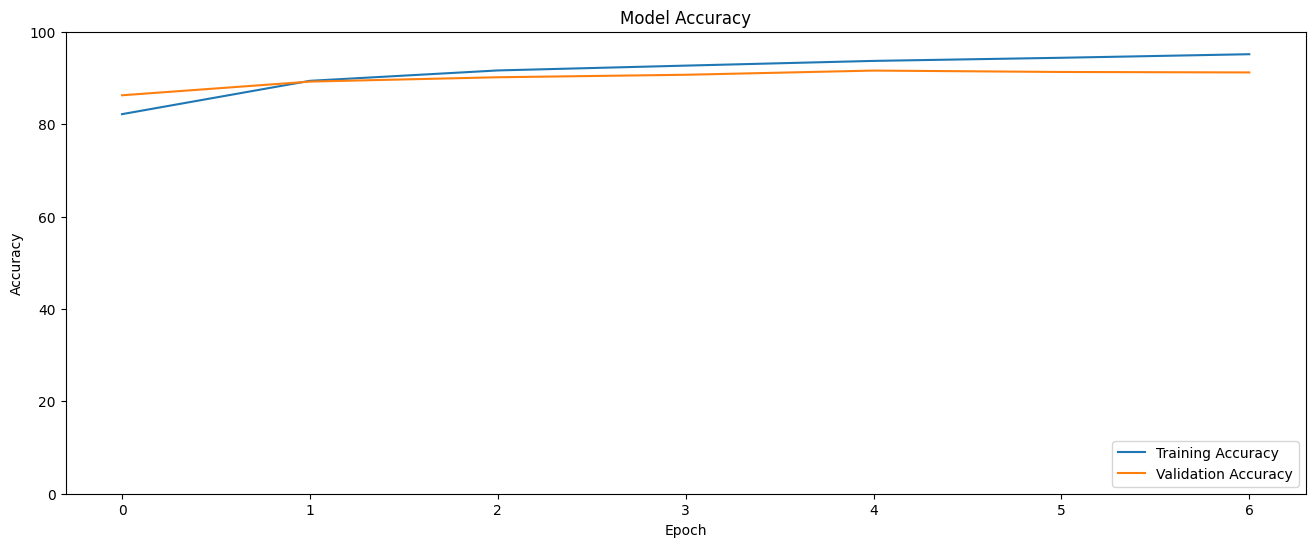

In [ ]:
metrics = history.history

plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim([0, 100])
plt.show()

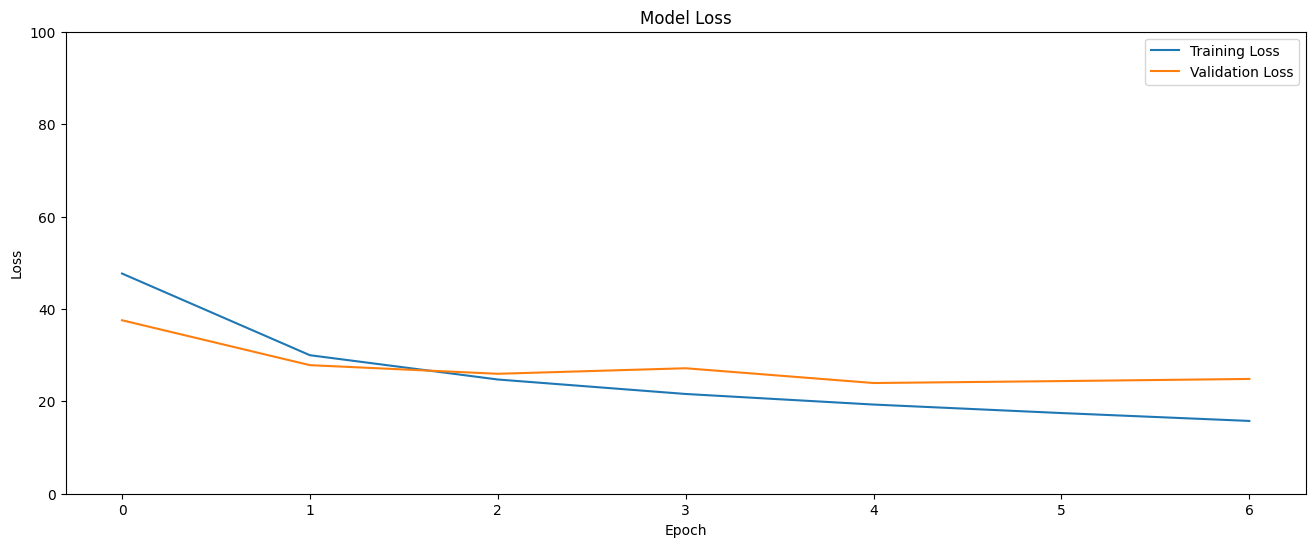

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['loss']), 100*np.array(metrics['val_loss']))
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim([0, 100])
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")

print(f"Accuracy score = {accuracy_score(y_test, y_pred)}")
print(f"Precision score = {precision_score(y_test, y_pred)}")
print(f"Recall score = {recall_score(y_test, y_pred)}")
print(f"F1 score = {f1_score(y_test, y_pred)}")

93/93 [==============================] - 3s 19ms/step
Accuracy score = 0.9115371678439287
Precision score = 0.9420289855072463
Recall score = 0.935468895078923
F1 score = 0.9387374796179827


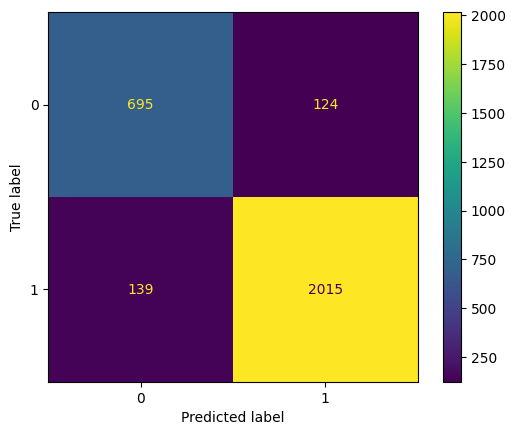

In [ ]:
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
display.plot()
plt.show()

#Undersampling After Hyperparameter Tuning (RMSProp)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto'))

Epoch 1/10
494/494 [==============================] - 51s 94ms/step - loss: 0.5719 - accuracy: 0.7688 - val_loss: 0.3830 - val_accuracy: 0.8591
Epoch 2/10
494/494 [==============================] - 44s 89ms/step - loss: 0.3440 - accuracy: 0.8802 - val_loss: 0.3328 - val_accuracy: 0.8819
Epoch 3/10
494/494 [==============================] - 47s 95ms/step - loss: 0.2809 - accuracy: 0.9076 - val_loss: 0.3057 - val_accuracy: 0.8865
Epoch 4/10
494/494 [==============================] - 44s 88ms/step - loss: 0.2441 - accuracy: 0.9181 - val_loss: 0.2896 - val_accuracy: 0.8885
Epoch 5/10
494/494 [==============================] - 45s 92ms/step - loss: 0.2176 - accuracy: 0.9292 - val_loss: 0.3180 - val_accuracy: 0.8931
Epoch 6/10
494/494 [==============================] - 44s 88ms/step - loss: 0.1966 - accuracy: 0.9397 - val_loss: 0.2723 - val_accuracy: 0.8976
Epoch 7/10
494/494 [==============================] - 46s 94ms/step - loss: 0.1759 - accuracy: 0.9468 - val_loss: 0.2961 - val_accuracy:

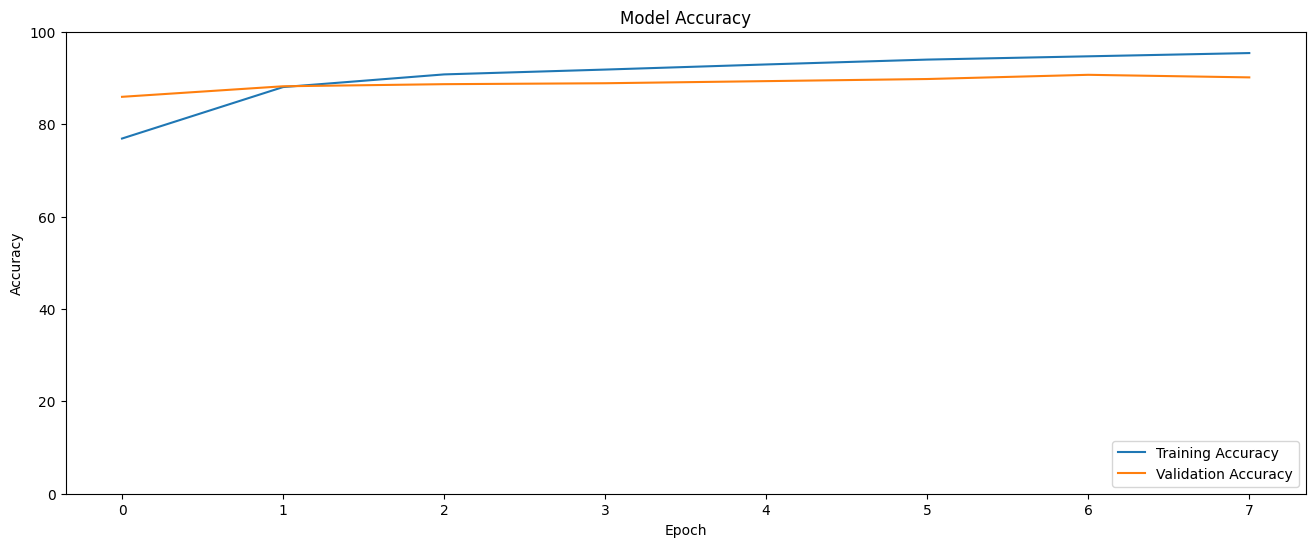

In [ ]:
metrics = history.history

plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim([0, 100])
plt.show()

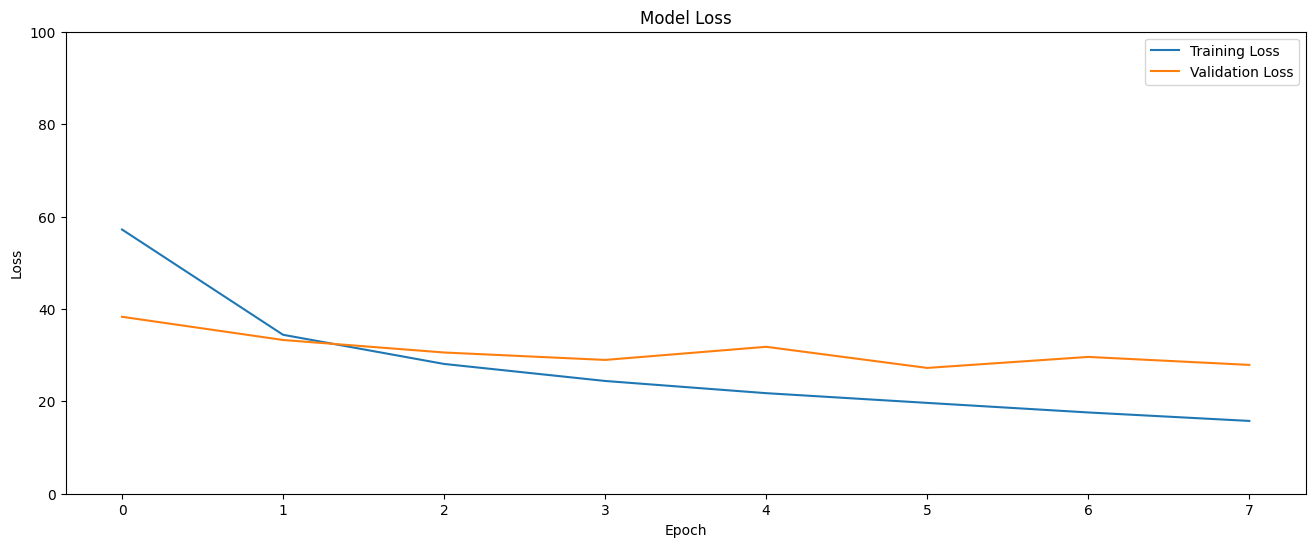

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['loss']), 100*np.array(metrics['val_loss']))
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim([0, 100])
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")

print(f"Accuracy score = {accuracy_score(y_test, y_pred)}")
print(f"Precision score = {precision_score(y_test, y_pred)}")
print(f"Recall score = {recall_score(y_test, y_pred)}")
print(f"F1 score = {f1_score(y_test, y_pred)}")

62/62 [==============================] - 2s 20ms/step
Accuracy score = 0.8819057273188039
Precision score = 0.9034424853064652
Recall score = 0.9011725293132329
F1 score = 0.9023060796645703


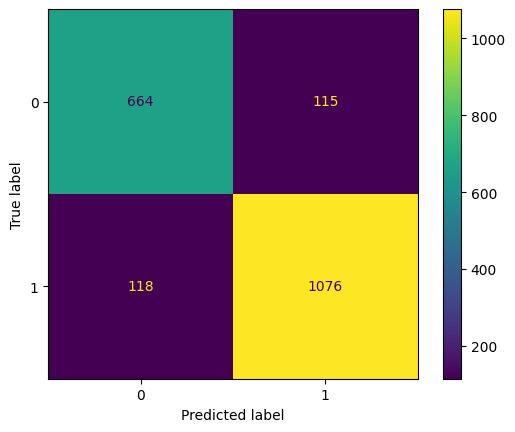

In [ ]:
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
display.plot()
plt.show()

#Original Before Hyperparameter Tuning (RMSProp)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val), callbacks=EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto'))

Epoch 1/10
1487/1487 [==============================] - 95s 59ms/step - loss: 0.4367 - accuracy: 0.8306 - val_loss: 0.3354 - val_accuracy: 0.8702
Epoch 2/10
1487/1487 [==============================] - 83s 56ms/step - loss: 0.2976 - accuracy: 0.8911 - val_loss: 0.2925 - val_accuracy: 0.8937
Epoch 3/10
1487/1487 [==============================] - 85s 57ms/step - loss: 0.2492 - accuracy: 0.9117 - val_loss: 0.2648 - val_accuracy: 0.8981
Epoch 4/10
1487/1487 [==============================] - 83s 56ms/step - loss: 0.2196 - accuracy: 0.9262 - val_loss: 0.2516 - val_accuracy: 0.9035
Epoch 5/10
1487/1487 [==============================] - 83s 56ms/step - loss: 0.2012 - accuracy: 0.9347 - val_loss: 0.2645 - val_accuracy: 0.9115
Epoch 6/10
1487/1487 [==============================] - 84s 56ms/step - loss: 0.1825 - accuracy: 0.9429 - val_loss: 0.2689 - val_accuracy: 0.9051
Epoch 6: early stopping


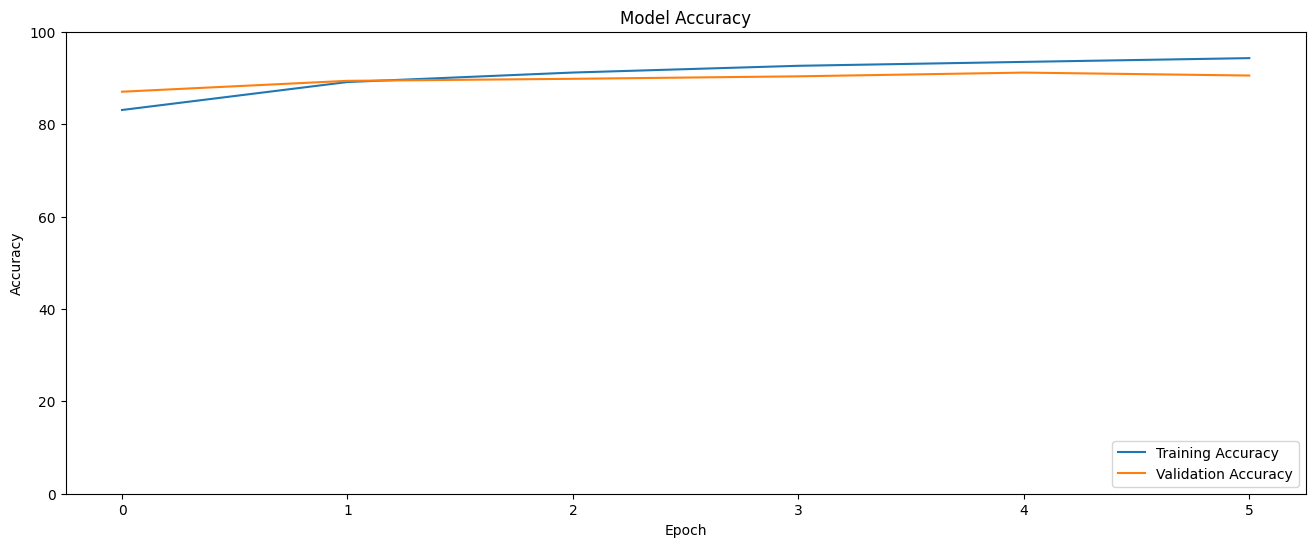

In [ ]:
metrics = history.history

plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim([0, 100])
plt.show()

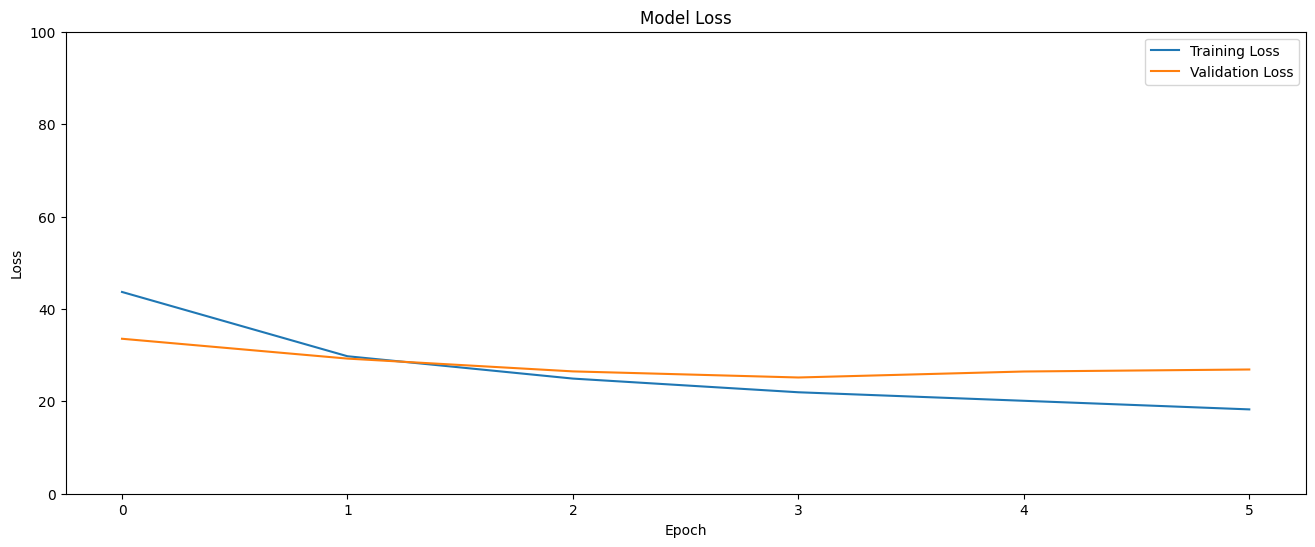

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['loss']), 100*np.array(metrics['val_loss']))
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim([0, 100])
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")

print(f"Accuracy score = {accuracy_score(y_test, y_pred)}")
print(f"Precision score = {precision_score(y_test, y_pred)}")
print(f"Recall score = {recall_score(y_test, y_pred)}")
print(f"F1 score = {f1_score(y_test, y_pred)}")

93/93 [==============================] - 4s 28ms/step
Accuracy score = 0.908509922637067
Precision score = 0.934040590405904
Recall score = 0.9401114206128134
F1 score = 0.937066173068024


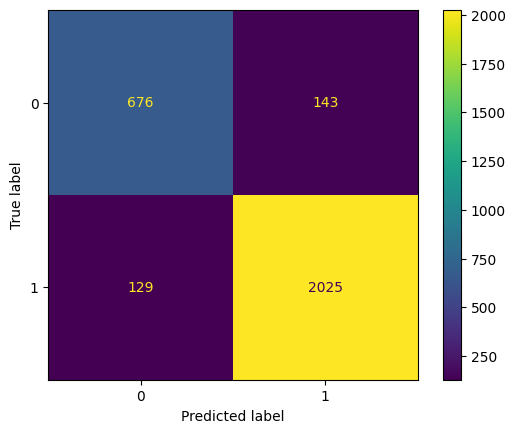

In [ ]:
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
display.plot()
plt.show()

#Undersampling Before Hyperparameter Tuning (RMSProp)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val), callbacks=EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto'))

Epoch 1/10
987/987 [==============================] - 71s 68ms/step - loss: 0.5296 - accuracy: 0.7770 - val_loss: 0.4249 - val_accuracy: 0.8338
Epoch 2/10
987/987 [==============================] - 66s 67ms/step - loss: 0.3531 - accuracy: 0.8734 - val_loss: 0.3555 - val_accuracy: 0.8632
Epoch 3/10
987/987 [==============================] - 65s 66ms/step - loss: 0.2901 - accuracy: 0.8977 - val_loss: 0.3679 - val_accuracy: 0.8723
Epoch 4/10
987/987 [==============================] - 65s 65ms/step - loss: 0.2517 - accuracy: 0.9165 - val_loss: 0.3963 - val_accuracy: 0.8464
Epoch 4: early stopping


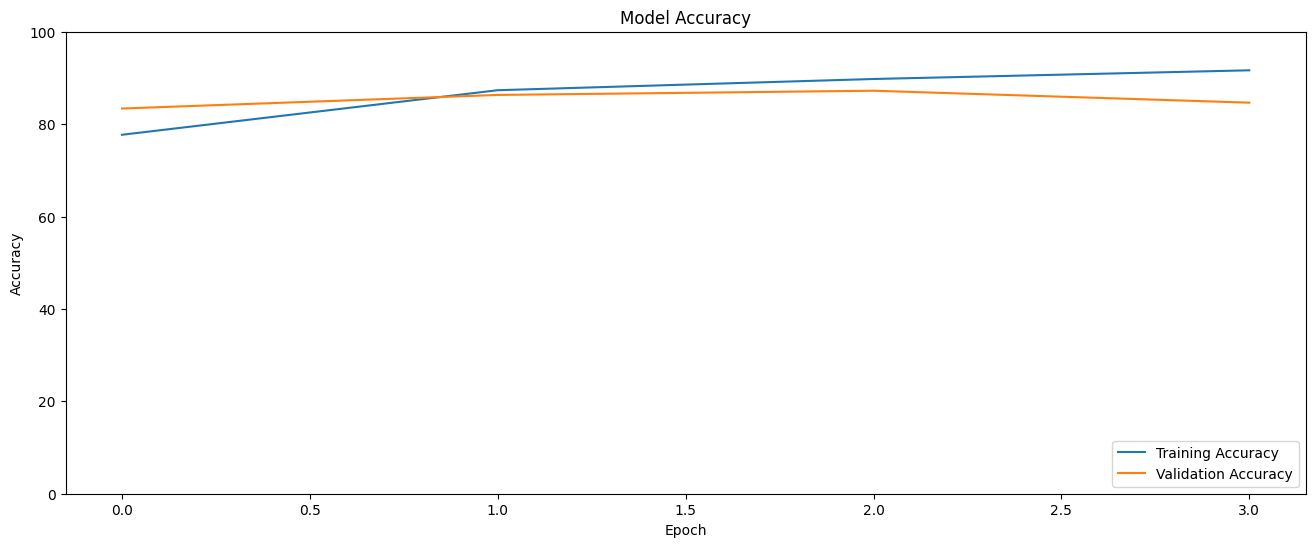

In [ ]:
metrics = history.history

plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim([0, 100])
plt.show()

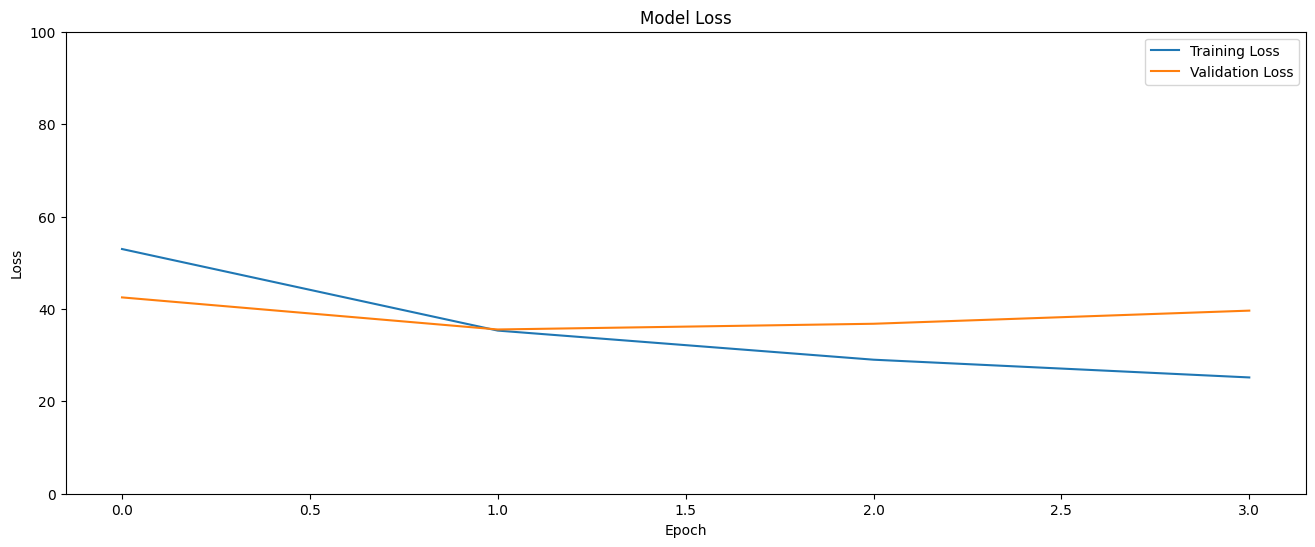

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['loss']), 100*np.array(metrics['val_loss']))
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim([0, 100])
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")

print(f"Accuracy score = {accuracy_score(y_test, y_pred)}")
print(f"Precision score = {precision_score(y_test, y_pred)}")
print(f"Recall score = {recall_score(y_test, y_pred)}")
print(f"F1 score = {f1_score(y_test, y_pred)}")

62/62 [==============================] - 2s 19ms/step
Accuracy score = 0.8504815002534212
Precision score = 0.8237577639751553
Recall score = 0.9397697077059345
F1 score = 0.8779478692594125


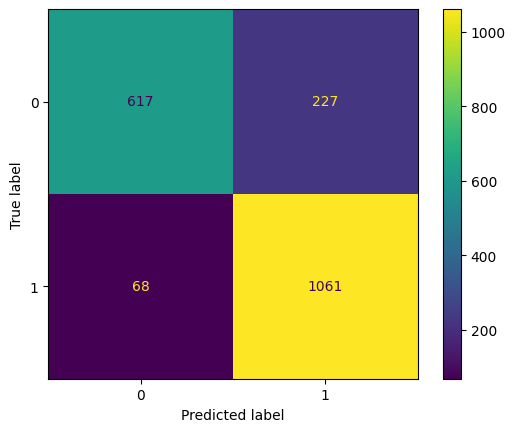

In [ ]:
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
display.plot()
plt.show()

#Best Trial (Input Dimension Changed)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto'))

Epoch 1/10
744/744 [==============================] - 78s 99ms/step - loss: 0.4766 - accuracy: 0.8216 - val_loss: 0.3755 - val_accuracy: 0.8624
Epoch 2/10
744/744 [==============================] - 71s 95ms/step - loss: 0.2998 - accuracy: 0.8937 - val_loss: 0.2783 - val_accuracy: 0.8920
Epoch 3/10
744/744 [==============================] - 75s 100ms/step - loss: 0.2472 - accuracy: 0.9162 - val_loss: 0.2596 - val_accuracy: 0.9014
Epoch 4/10
744/744 [==============================] - 71s 95ms/step - loss: 0.2159 - accuracy: 0.9266 - val_loss: 0.2716 - val_accuracy: 0.9068
Epoch 5/10
744/744 [==============================] - 73s 98ms/step - loss: 0.1930 - accuracy: 0.9368 - val_loss: 0.2396 - val_accuracy: 0.9159
Epoch 6/10
744/744 [==============================] - 73s 98ms/step - loss: 0.1746 - accuracy: 0.9436 - val_loss: 0.2438 - val_accuracy: 0.9129
Epoch 7/10
744/744 [==============================] - 71s 96ms/step - loss: 0.1575 - accuracy: 0.9513 - val_loss: 0.2484 - val_accuracy

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")

print(f"Accuracy score = {accuracy_score(y_test, y_pred)}")
print(f"Precision score = {precision_score(y_test, y_pred)}")
print(f"Recall score = {recall_score(y_test, y_pred)}")
print(f"F1 score = {f1_score(y_test, y_pred)}")

93/93 [==============================] - 4s 32ms/step
Accuracy score = 0.9054826774302052
Precision score = 0.9293577981651376
Recall score = 0.9410125406409661
F1 score = 0.9351488576044311


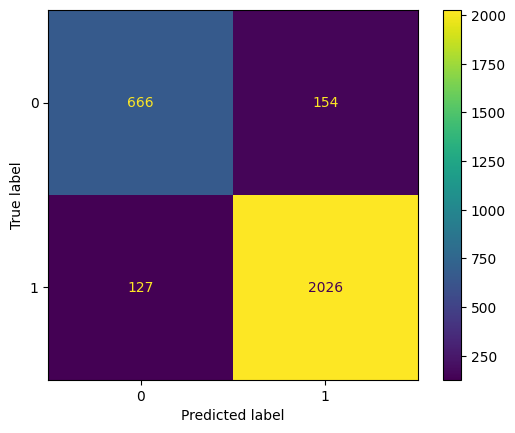

In [ ]:
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
display.plot()
plt.show()

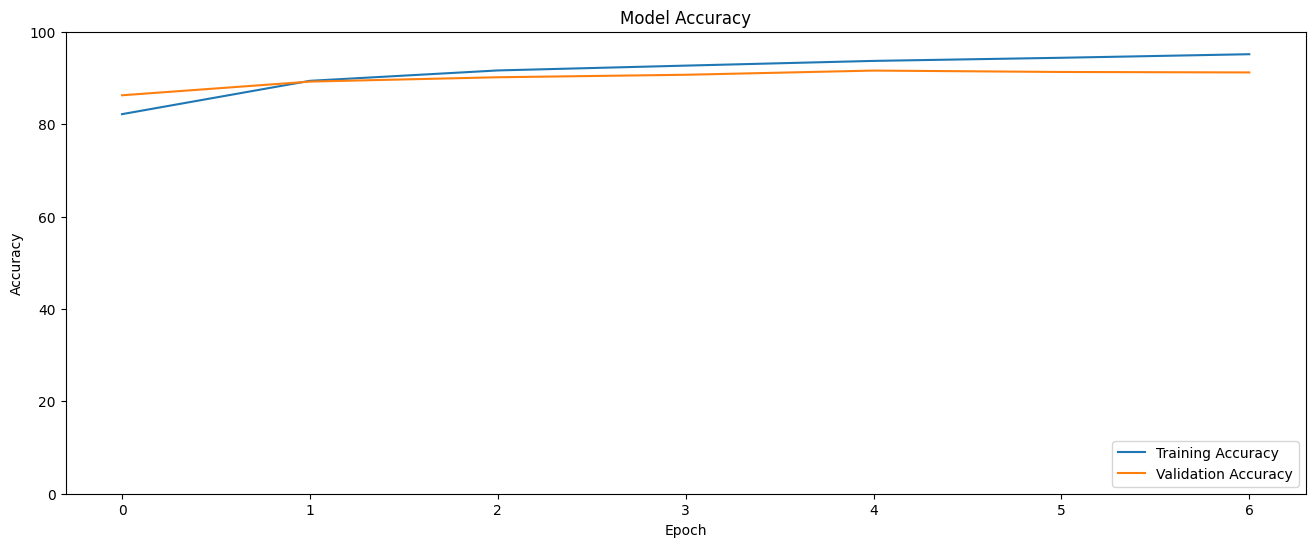

In [ ]:
metrics = history.history

plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim([0, 100])
plt.show()

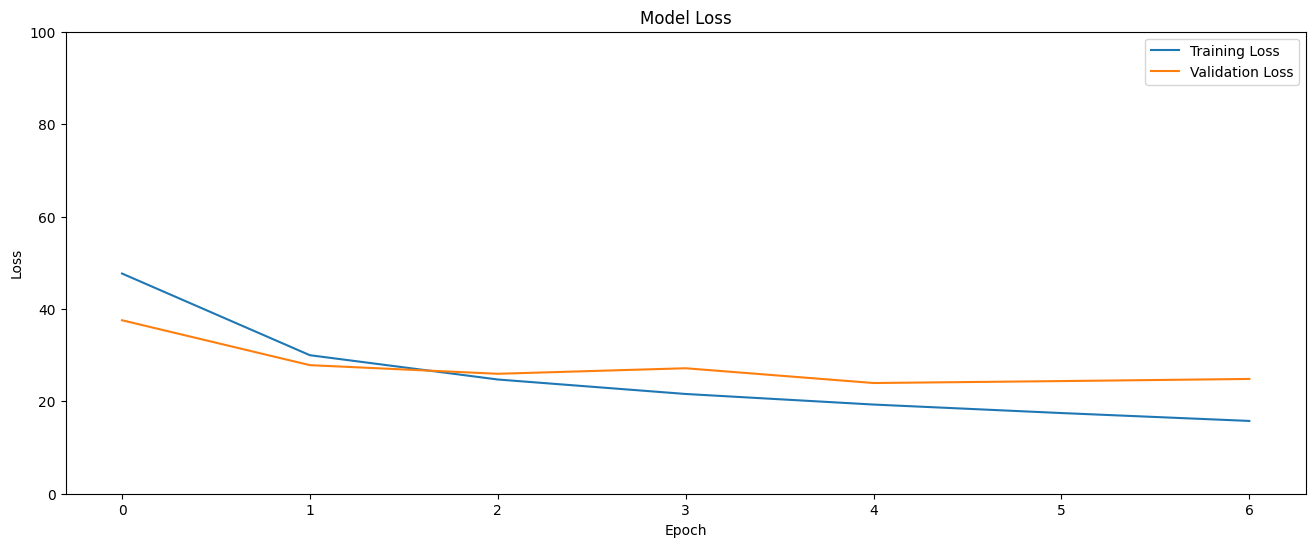

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['loss']), 100*np.array(metrics['val_loss']))
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim([0, 100])
plt.show()

#Best Trial (Embedding Layer = 300)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto'))

Epoch 1/10
744/744 [==============================] - 82s 106ms/step - loss: 0.4725 - accuracy: 0.8190 - val_loss: 0.3336 - val_accuracy: 0.8695
Epoch 2/10
744/744 [==============================] - 75s 100ms/step - loss: 0.3025 - accuracy: 0.8928 - val_loss: 0.2764 - val_accuracy: 0.8907
Epoch 3/10
744/744 [==============================] - 76s 102ms/step - loss: 0.2503 - accuracy: 0.9122 - val_loss: 0.2831 - val_accuracy: 0.9018
Epoch 4/10
744/744 [==============================] - 75s 100ms/step - loss: 0.2181 - accuracy: 0.9276 - val_loss: 0.2424 - val_accuracy: 0.9115
Epoch 5/10
744/744 [==============================] - 75s 100ms/step - loss: 0.1973 - accuracy: 0.9371 - val_loss: 0.2582 - val_accuracy: 0.9183
Epoch 6/10
744/744 [==============================] - 76s 103ms/step - loss: 0.1776 - accuracy: 0.9451 - val_loss: 0.2334 - val_accuracy: 0.9142
Epoch 7/10
744/744 [==============================] - 74s 100ms/step - loss: 0.1600 - accuracy: 0.9517 - val_loss: 0.2495 - val_ac

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")

print(f"Accuracy score = {accuracy_score(y_test, y_pred)}")
print(f"Precision score = {precision_score(y_test, y_pred)}")
print(f"Recall score = {recall_score(y_test, y_pred)}")
print(f"F1 score = {f1_score(y_test, y_pred)}")

93/93 [==============================] - 3s 20ms/step
Accuracy score = 0.9075008409014463
Precision score = 0.9191964285714286
Recall score = 0.9563399907106364
F1 score = 0.9374004097427726


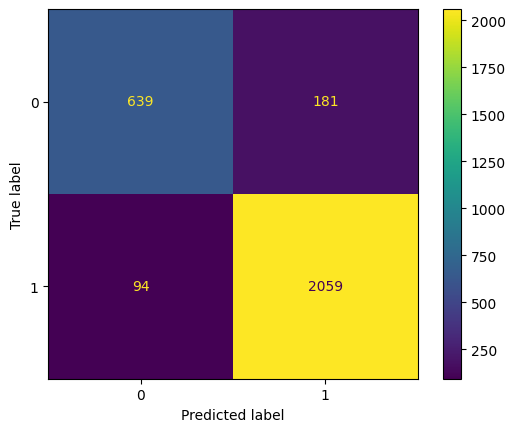

In [ ]:
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
display.plot()
plt.show()

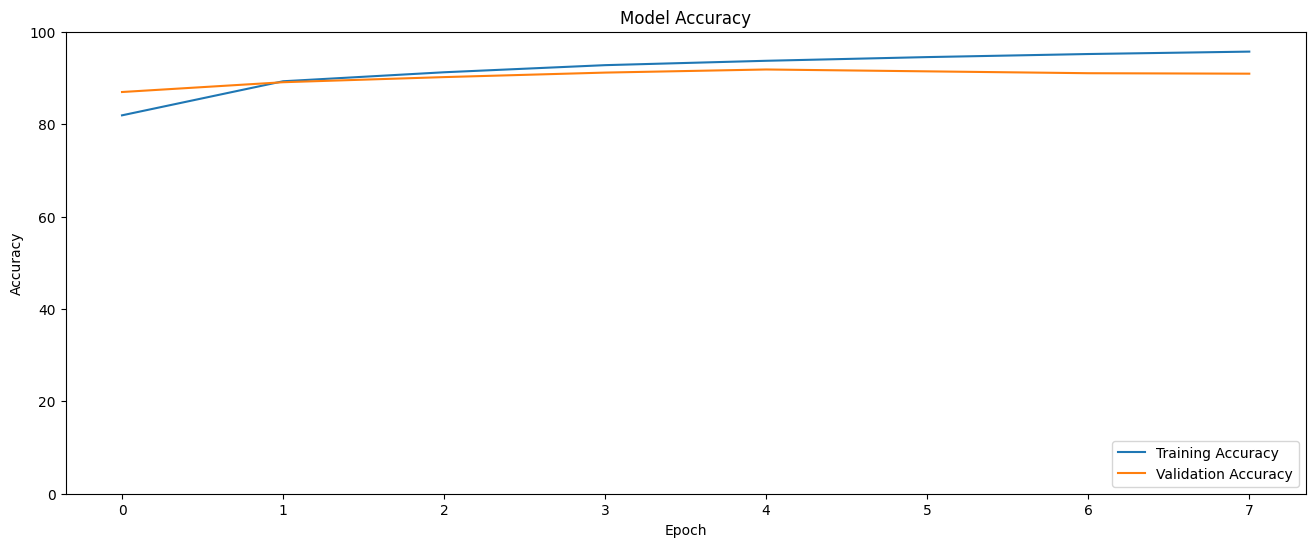

In [ ]:
metrics = history.history

plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim([0, 100])
plt.show()

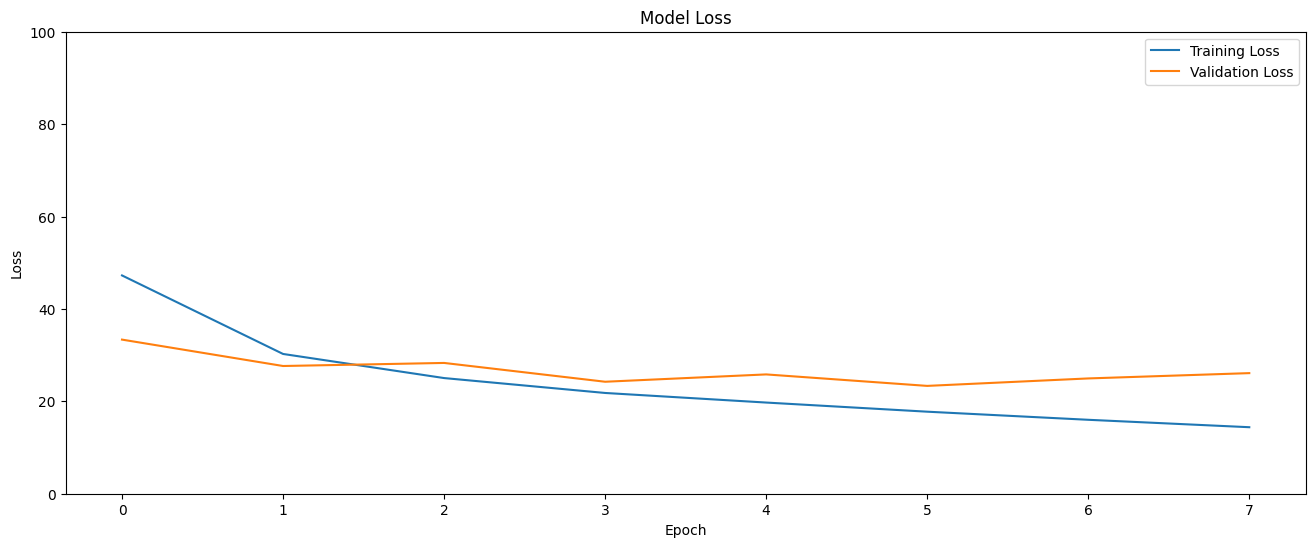

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['loss']), 100*np.array(metrics['val_loss']))
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim([0, 100])
plt.show()

#Best Trial (Embedding Layer = 300)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto'))

Epoch 1/10
744/744 [==============================] - 90s 112ms/step - loss: 0.4738 - accuracy: 0.8211 - val_loss: 0.3481 - val_accuracy: 0.8675
Epoch 2/10
744/744 [==============================] - 86s 116ms/step - loss: 0.3031 - accuracy: 0.8922 - val_loss: 0.2875 - val_accuracy: 0.8924
Epoch 3/10
744/744 [==============================] - 82s 110ms/step - loss: 0.2538 - accuracy: 0.9125 - val_loss: 0.2840 - val_accuracy: 0.8883
Epoch 4/10
744/744 [==============================] - 86s 116ms/step - loss: 0.2222 - accuracy: 0.9253 - val_loss: 0.2542 - val_accuracy: 0.9038
Epoch 5/10
744/744 [==============================] - 83s 111ms/step - loss: 0.1969 - accuracy: 0.9357 - val_loss: 0.2659 - val_accuracy: 0.8984
Epoch 6/10
744/744 [==============================] - 80s 108ms/step - loss: 0.1764 - accuracy: 0.9440 - val_loss: 0.2531 - val_accuracy: 0.9132
Epoch 7/10
744/744 [==============================] - 80s 108ms/step - loss: 0.1575 - accuracy: 0.9515 - val_loss: 0.2633 - val_ac

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")

print(f"Accuracy score = {accuracy_score(y_test, y_pred)}")
print(f"Precision score = {precision_score(y_test, y_pred)}")
print(f"Recall score = {recall_score(y_test, y_pred)}")
print(f"F1 score = {f1_score(y_test, y_pred)}")

93/93 [==============================] - 3s 19ms/step
Accuracy score = 0.9061553985872856
Precision score = 0.9345537757437071
Recall score = 0.9375573921028466
F1 score = 0.9360531744212698


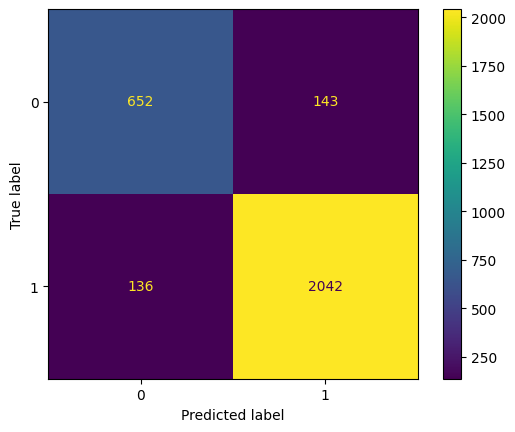

In [ ]:
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
display.plot()
plt.show()

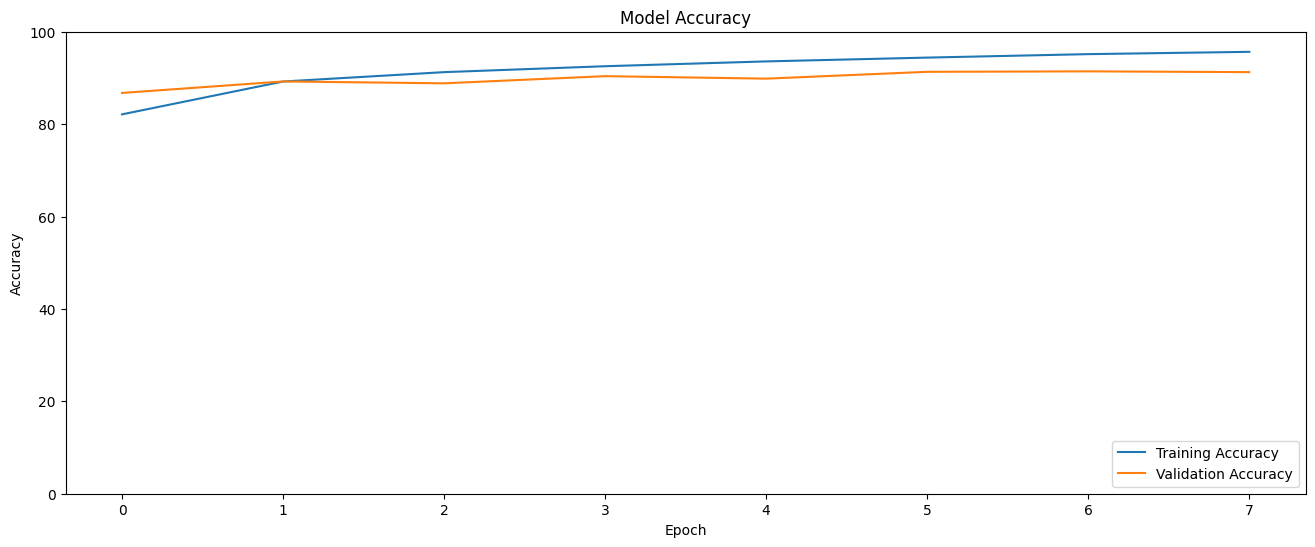

In [ ]:
metrics = history.history

plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim([0, 100])
plt.show()

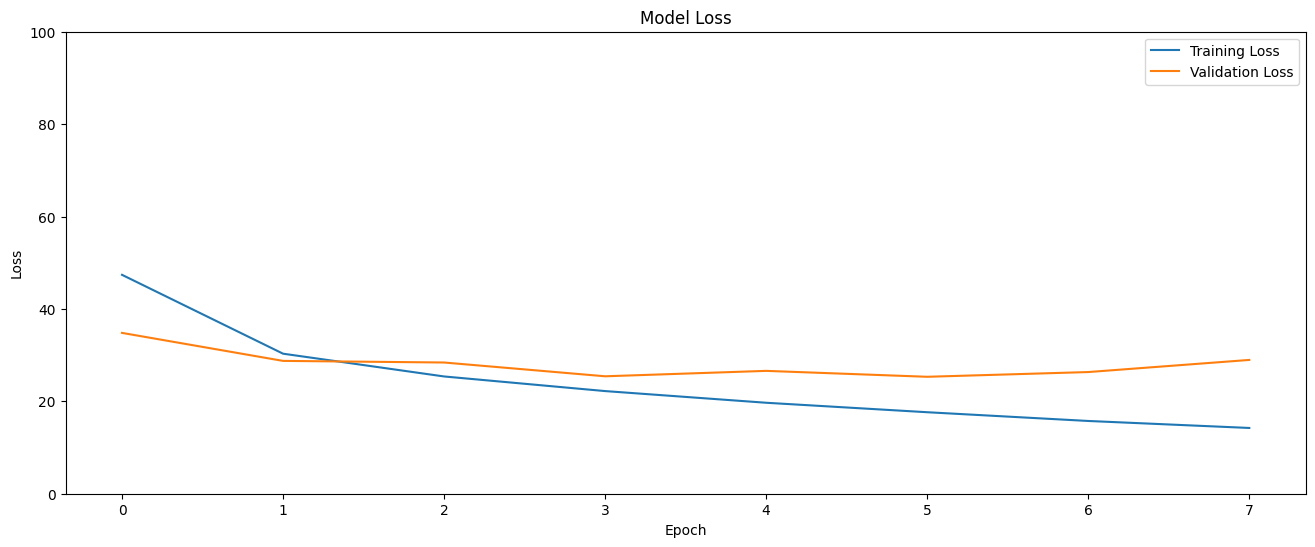

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['loss']), 100*np.array(metrics['val_loss']))
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim([0, 100])
plt.show()

#Best Trial (Original Data, 80-10-10)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto'))

Epoch 1/10
744/744 [==============================] - 75s 95ms/step - loss: 0.4982 - accuracy: 0.8082 - val_loss: 0.3626 - val_accuracy: 0.8641
Epoch 2/10
744/744 [==============================] - 69s 92ms/step - loss: 0.3051 - accuracy: 0.8934 - val_loss: 0.3198 - val_accuracy: 0.8742
Epoch 3/10
744/744 [==============================] - 69s 93ms/step - loss: 0.2516 - accuracy: 0.9140 - val_loss: 0.2755 - val_accuracy: 0.8974
Epoch 4/10
744/744 [==============================] - 68s 91ms/step - loss: 0.2217 - accuracy: 0.9256 - val_loss: 0.2855 - val_accuracy: 0.8984
Epoch 5/10
744/744 [==============================] - 68s 91ms/step - loss: 0.1979 - accuracy: 0.9357 - val_loss: 0.3109 - val_accuracy: 0.9068
Epoch 5: early stopping


In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")

print(f"Accuracy score = {accuracy_score(y_test, y_pred)}")
print(f"Precision score = {precision_score(y_test, y_pred)}")
print(f"Recall score = {recall_score(y_test, y_pred)}")
print(f"F1 score = {f1_score(y_test, y_pred)}")

93/93 [==============================] - 2s 17ms/step
Accuracy score = 0.8970736629667003
Precision score = 0.9086115992970123
Recall score = 0.9547553093259464
F1 score = 0.9311121116614138


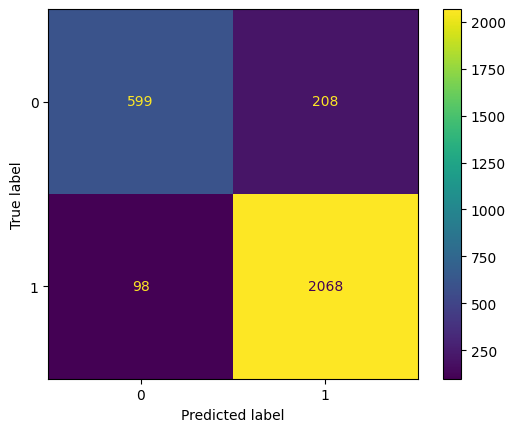

In [ ]:
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
display.plot()
plt.show()

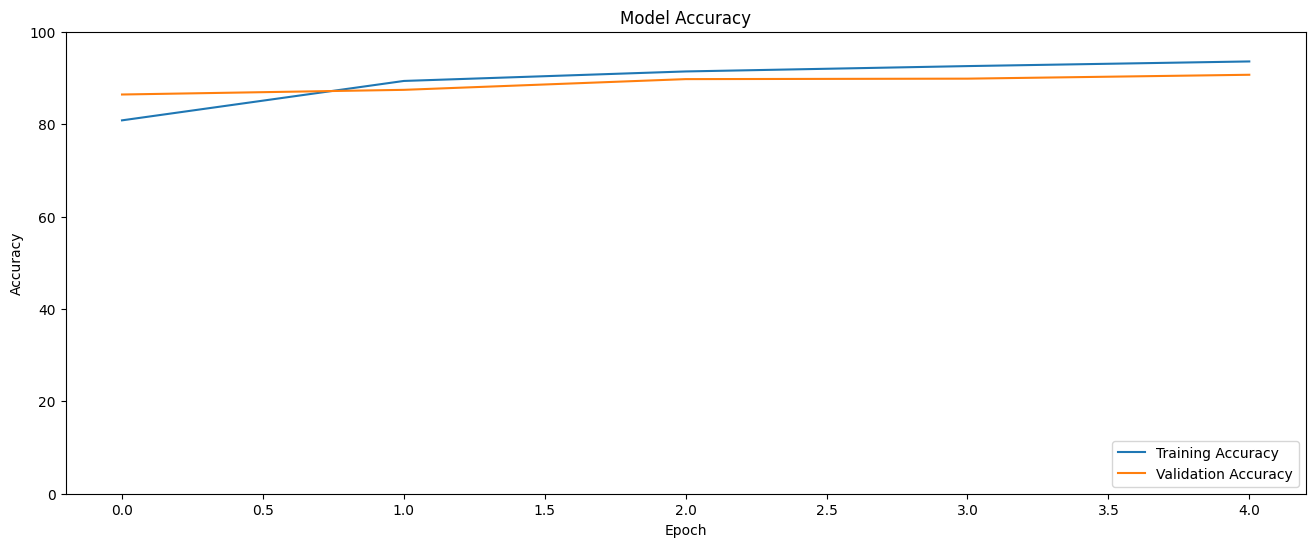

In [ ]:
metrics = history.history

plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim([0, 100])
plt.show()

#Best Trial (Undersampling 10.000 Data, 80-10-10)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto'))

Epoch 1/10
494/494 [==============================] - 49s 91ms/step - loss: 0.5862 - accuracy: 0.7550 - val_loss: 0.3968 - val_accuracy: 0.8464
Epoch 2/10
494/494 [==============================] - 44s 88ms/step - loss: 0.3560 - accuracy: 0.8727 - val_loss: 0.3430 - val_accuracy: 0.8849
Epoch 3/10
494/494 [==============================] - 46s 93ms/step - loss: 0.2888 - accuracy: 0.9023 - val_loss: 0.3111 - val_accuracy: 0.8895
Epoch 4/10
494/494 [==============================] - 44s 88ms/step - loss: 0.2463 - accuracy: 0.9184 - val_loss: 0.2920 - val_accuracy: 0.8956
Epoch 5/10
494/494 [==============================] - 43s 87ms/step - loss: 0.2212 - accuracy: 0.9285 - val_loss: 0.3072 - val_accuracy: 0.9002
Epoch 6/10
494/494 [==============================] - 43s 87ms/step - loss: 0.1992 - accuracy: 0.9383 - val_loss: 0.2962 - val_accuracy: 0.9027
Epoch 6: early stopping


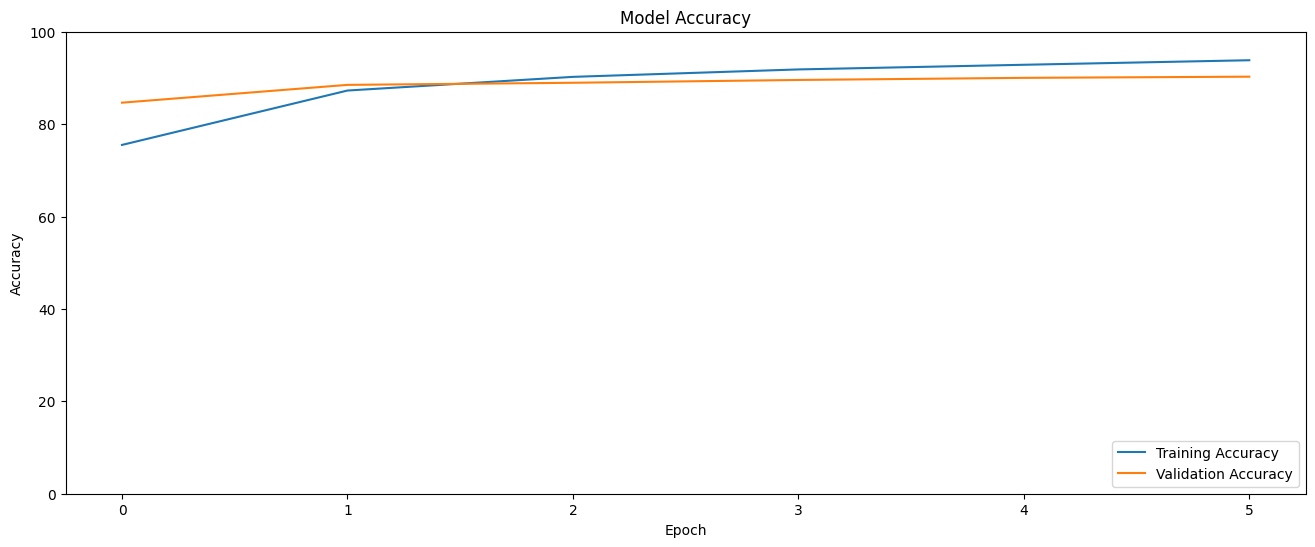

In [ ]:
metrics = history.history

plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim([0, 100])
plt.show()

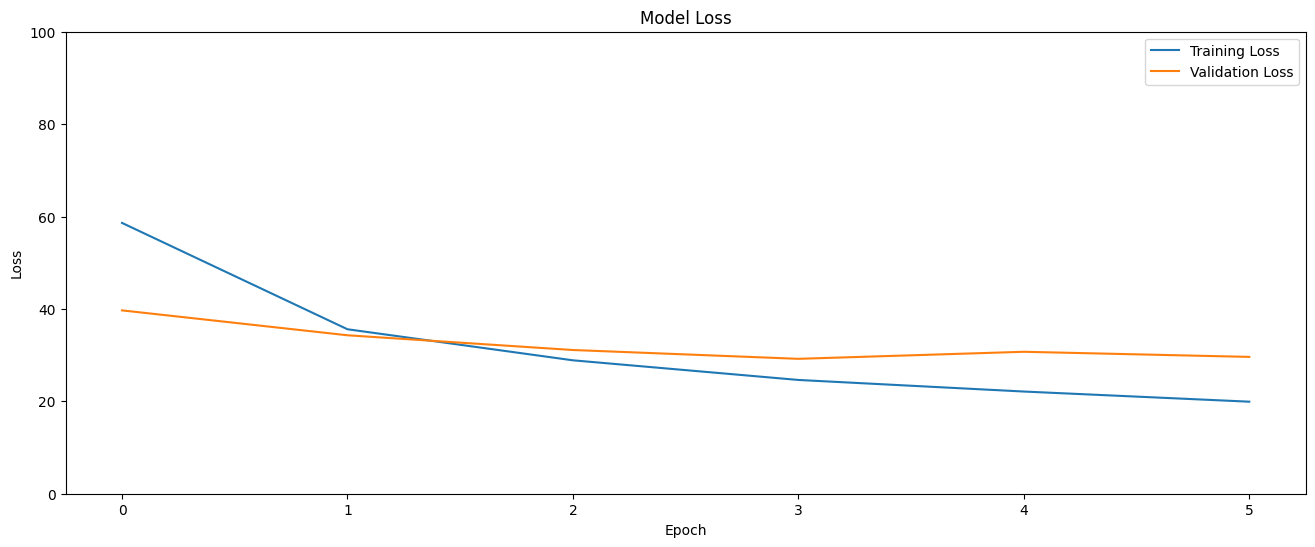

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['loss']), 100*np.array(metrics['val_loss']))
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim([0, 100])
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")

print(f"Accuracy score = {accuracy_score(y_test, y_pred)}")
print(f"Precision score = {precision_score(y_test, y_pred)}")
print(f"Recall score = {recall_score(y_test, y_pred)}")
print(f"F1 score = {f1_score(y_test, y_pred)}")

62/62 [==============================] - 1s 17ms/step
Accuracy score = 0.8768373035985808
Precision score = 0.9233576642335767
Recall score = 0.8642186165670367
F1 score = 0.8928098808998677


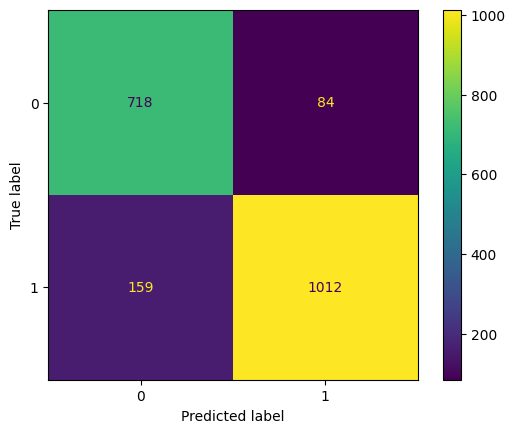

In [ ]:
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
display.plot()
plt.show()

#Hyperparameter Tuning

In [ ]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
import dill
import tensorflow as tf

class KerasModelWrapper:
    def __init__(self, embedding_dim=200, lstm_units=64, dense_units=32, dropout_rate=0.2, optimizer='rmsprop', epochs=10, batch_size=32):
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.dense_units = dense_units
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y, validation_data=None):
        self.model = create_model(
            embedding_dim=self.embedding_dim,
            lstm_units=self.lstm_units,
            dense_units=self.dense_units,
            dropout_rate=self.dropout_rate,
            optimizer=self.optimizer
        )
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size,
                       validation_data=validation_data, callbacks=[early_stopping], verbose=0)

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def get_params(self, deep=True):
        return {
            'embedding_dim': self.embedding_dim,
            'lstm_units': self.lstm_units,
            'dense_units': self.dense_units,
            'dropout_rate': self.dropout_rate,
            'optimizer': self.optimizer,
            'epochs': self.epochs,
            'batch_size': self.batch_size
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

    def __getstate__(self):
        state = self.__dict__.copy()
        # Remove the model since it can't be pickled
        state['model'] = None
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)
        self.model = None

    def __reduce__(self):
        return (self.__class__, (self.embedding_dim, self.lstm_units, self.dense_units, self.dropout_rate, self.optimizer, self.epochs, self.batch_size))


In [ ]:
import joblib

# Set the parallel_backend to use joblib with dill
with joblib.parallel_backend('multiprocessing'):
    joblib.Parallel(n_jobs=-1, verbose=10, backend='multiprocessing', prefer="processes") #n_jobs -1 => pakai seluruh cpu

    model = KerasModelWrapper()

    param_grid = {
        'embedding_dim': [100, 200, 300],
        'optimizer': ['rmsprop', 'adam'],
        'batch_size': [16, 32]
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

    # Perform the search
    grid_search_result = grid_search.fit(x, y)

    print("Best: %f using %s" % (grid_search_result.best_score_, grid_search_result.best_params_))

    # Retrieve the best model parameters
    best_params = grid_search_result.best_params_

    # Create the best model with the optimal hyperparameters
    best_model = KerasModelWrapper(**best_params)
    best_model.fit(X_train, y_train, validation_data=(X_val, y_val))

    # Assuming you have a separate test set x_test, y_test
    # x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Fit the best model on the entire training set (optional)
    # best_model.fit(x_train, y_train)

    y_pred = best_model.predict(X_test)

    # Metrics and confusion matrix
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1 score:', f1_score(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    display.plot()
    plt.show()

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


186/186 [==============================] - 6s 23ms/step


186/186 [==============================] - 8s 22ms/step


186/186 [==============================] - 7s 32ms/step


186/186 [==============================] - 8s 22ms/step


163/186 [=========================>....] - ETA: 0s

186/186 [==============================] - 7s 24ms/step


186/186 [==============================] - 11s 34ms/step


186/186 [==============================] - 11s 35ms/step


186/186 [==============================] - 8s 34ms/step


186/186 [==============================] - 11s 47ms/step


186/186 [==============================] - 8s 34ms/step


186/186 [==============================] - 12s 53ms/step


186/186 [==============================] - 9s 39ms/step


186/186 [==============================] - 12s 48ms/step


186/186 [==============================] - 13s 60ms/step


186/186 [==============================] - 4s 20ms/step


Best: 0.906822 using {'embedding_dim': 100}


NameError: name 'X_train' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
clf = KerasModelWrapper(batch_size=32)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

124/124 [==============================] - 4s 27ms/step


In [ ]:
print(f"Accuracy score = {accuracy_score(y_test, y_pred)}")
print(f"Precision score = {precision_score(y_test, y_pred)}")
print(f"Recall score = {recall_score(y_test, y_pred)}")
print(f"F1 score = {f1_score(y_test, y_pred)}")

Accuracy score = 0.8953370501773948
Precision score = 0.8952341824157765
Recall score = 0.9323919554985024
F1 score = 0.9134353385034584


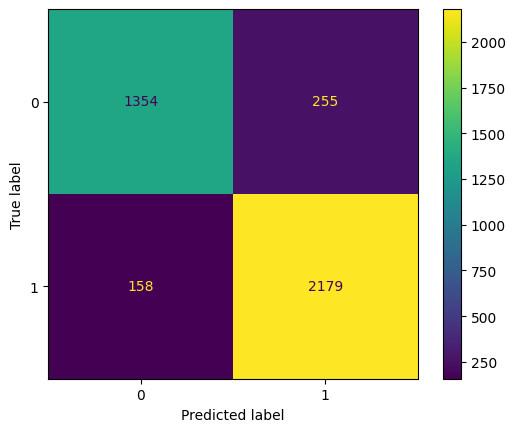

In [ ]:
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
display.plot()
plt.show()